<h1 style="font-size:2rem; color:blue;"> Snow climatology using the ESA CCI on ground snow product level L3C daily from AVHRR over the period 1982-2019 in the Mediterranean area without imputation of missing data </h1>

<h1 style="font-size:1.2rem; color:black;"> In this notebook, we will first explore the snow fraction data from the ESA CCI product. Then, we will make monthly, seasonal, and annual climatologies in 5 points located in the middle and high atlas over the period 1982-2018.  </h1>   

## 1. Importing python moduls 

In [1]:
# To reload external files automatically (ex: utils)
%load_ext autoreload
%autoreload 2

import os 
import numpy as np
import pandas as pd
import netCDF4 as nc
from netCDF4 import Dataset
import datetime as dt
import calendar as cld
import matplotlib.pyplot as plt
import xarray as xr
from os import listdir
from os.path import isfile, join
import cartopy.crs as ccrs
import cartopy 
import proplot as plot  # New plot library (https://proplot.readthedocs.io/en/latest/)
from scipy import stats
import sys
import pymannkendall as mk
import calendar
import time

#import xesmf as xe # For regridding (https://xesmf.readthedocs.io/en/latest/)
plot.rc['savefig.dpi'] = 300 # 1200 is too big! #https://proplot.readthedocs.io/en/latest/basics.html#Creating-figures
sys.path.insert(1, '/home/hamid/Desktop/results/') # to include my util file in previous directory

# ============================================================================
# Models for parallelisation
import multiprocessing 
from dask.distributed import Client
from dask import delayed
from dask import compute
# client = Client(n_workers=4, threads_per_worker=3, memory_limit='4GB')
client = Client(n_workers=16, threads_per_worker=1, memory_limit='2GB')
# client = Client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 16
Total threads: 16,Total memory: 29.80 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35159,Workers: 16
Dashboard: http://127.0.0.1:8787/status,Total threads: 16
Started: Just now,Total memory: 29.80 GiB
Comm: tcp://127.0.0.1:45829,Total threads: 1
Dashboard: http://127.0.0.1:40295/status,Memory: 1.86 GiB
Nanny: tcp://127.0.0.1:42381,


In [2]:
client.close()

## 2. Check and import data 

In [3]:
# Path to data
path_snow_CCI = '/home/hamid/Desktop/monthly_cci_snow/monthly'

ds = xr.open_mfdataset(path_snow_CCI+'/*.nc')

print(ds)
print("==================================================================================")
ds   

<xarray.Dataset>
Dimensions:          (time: 441, lat: 3600, lon: 7200)
Coordinates:
  * time             (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31
  * lat              (lat) float64 -89.97 -89.92 -89.88 ... 89.88 89.92 89.97
  * lon              (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    coverage         (time, lat, lon) float64 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    coverage_interp  (time, lat, lon) float64 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
Attributes: (12/43)
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on grou

<xarray.Dataset>
Dimensions:          (time: 441, lat: 3600, lon: 7200)
Coordinates:
  * time             (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31
  * lat              (lat) float64 -89.97 -89.92 -89.88 ... 89.88 89.92 89.97
  * lon              (lon) float64 -180.0 -179.9 -179.9 ... 179.9 179.9 180.0
Data variables:
    scfg_interp      (time, lat, lon) float64 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    coverage         (time, lat, lon) float64 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    coverage_interp  (time, lat, lon) float64 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    mask_ice         (time, lat, lon) float32 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
    mask_water       (time, lat, lon) float32 dask.array<chunksize=(12, 3600, 7200), meta=np.ndarray>
Attributes: (12/43)
    processed:                  A linear interpolation on the time dimension ...
    title:                      ESA CCI snow on ground product level L3C dail...
    institution:                Remote Sensing Research Group, Institute of G...
    source:                     AVHRR_NOAA-7_GAC mosaic from ESA Cloud CCI pr...
    date_created:               20211109T162200Z
    history:                    20211109T162200Z: ESA snow_cci SCF processing...
    ...                         ...
    license:                    ESA CCI Data Policy: free and open access
    platform:                   NOAA-7
    sensor:                     AVHRR
    spatial_resolution:         0.05 degree
    key_variables:              scfg
    doi:                        10.5285/3f034f4a08854eb59d58e1fa92d207b6

<h1 style="font-size:1.2rem; color:black;"> Select variable (scfg_interp in our case)  </h1>  

In [4]:
scfg_interp = ds['scfg_interp']
print("======================== scfg ============================")
scfg_interp

======================== scfg ============================


<xarray.DataArray 'scfg_interp' (time: 441, lat: 3600, lon: 7200)>
dask.array<concatenate, shape=(441, 3600, 7200), dtype=float64, chunksize=(12, 3600, 7200), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31
  * lat      (lat) float64 -89.97 -89.92 -89.88 -89.83 ... 89.88 89.92 89.97
  * lon      (lon) float64 -180.0 -179.9 -179.9 -179.8 ... 179.9 179.9 180.0

<h1 style="font-size:1.2rem; color:black;"> Extract the study area  </h1>  

In [5]:
# Atlas domain
latlim_ext,lonlim_ext=slice(30,36), slice(-10,-4)
scfg_interp_atlas=scfg_interp.sel(lat=latlim_ext, lon=lonlim_ext)

In [6]:
scfg_interp_atlas

<xarray.DataArray 'scfg_interp' (time: 441, lat: 120, lon: 120)>
dask.array<getitem, shape=(441, 120, 120), dtype=float64, chunksize=(12, 120, 120), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31
  * lat      (lat) float64 30.02 30.07 30.12 30.18 ... 35.83 35.88 35.92 35.98
  * lon      (lon) float64 -9.975 -9.925 -9.875 -9.825 ... -4.125 -4.075 -4.025

<h1 style="font-size:1.2rem; color:black;"> Quick view of scfg_interp </h1>  

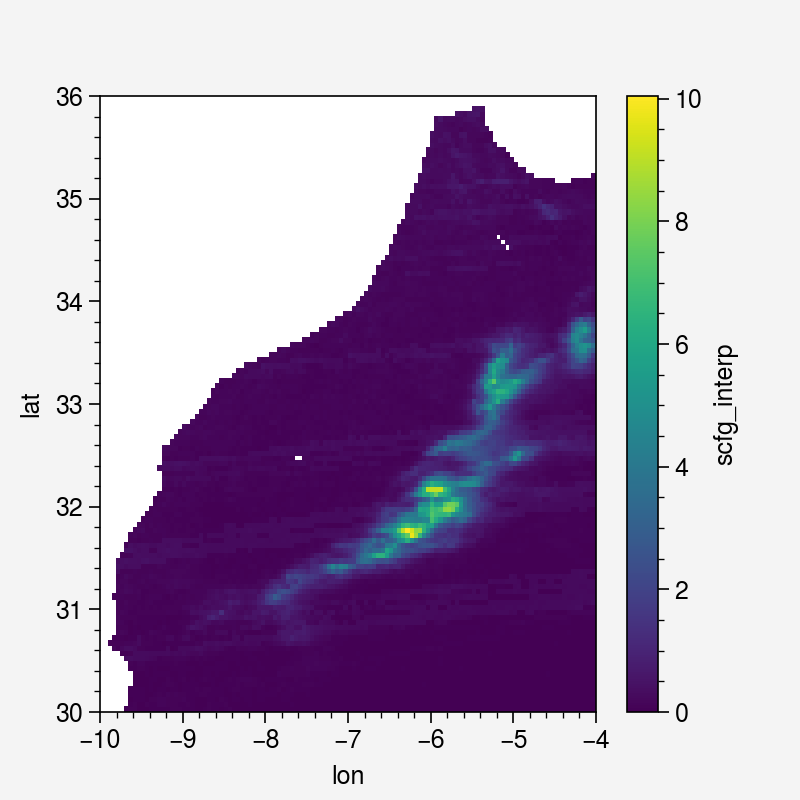

In [7]:
aux = scfg_interp_atlas.mean(dim = 'time', skipna=True)
aux.plot()

## 2. Extract the 5 points in Hight Atlas

In [8]:
latlim_ext1,lonlim_ext1=slice(30.95,30.99), slice(-8.45,-8.42)
latlim_ext2,lonlim_ext2=slice(31.06,31.08), slice(-8.426,-8.424)
latlim_ext3,lonlim_ext3=slice(31.04,31.08), slice(-7.93,-7.89)
latlim_ext4,lonlim_ext4=slice(32.37,32.39), slice(-6.126,-6.124)
latlim_ext5,lonlim_ext5=slice(33.49,33.53), slice(-5.13,-5.09)

In [9]:
P1 = scfg_interp_atlas.sel(lat=latlim_ext1, lon=lonlim_ext1)
P2 = scfg_interp_atlas.sel(lat=latlim_ext2, lon=lonlim_ext2)
P3 = scfg_interp_atlas.sel(lat=latlim_ext3, lon=lonlim_ext3) 
P4 = scfg_interp_atlas.sel(lat=latlim_ext4, lon=lonlim_ext4)
P5 = scfg_interp_atlas.sel(lat=latlim_ext5, lon=lonlim_ext5)

In [10]:
for P in [(P1, "P1"), (P2, "P2"), (P3, "P3"), (P4, "P4"), (P5, "P5")]:
    print("================"+ P[1] + "==================")
    print(P[0])

================P1==================
<xarray.DataArray 'scfg_interp' (time: 441, lat: 1, lon: 1)>
dask.array<getitem, shape=(441, 1, 1), dtype=float64, chunksize=(12, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31
  * lat      (lat) float64 30.98
  * lon      (lon) float64 -8.425
================P2==================
<xarray.DataArray 'scfg_interp' (time: 441, lat: 1, lon: 1)>
dask.array<getitem, shape=(441, 1, 1), dtype=float64, chunksize=(12, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31
  * lat      (lat) float64 31.07
  * lon      (lon) float64 -8.425
================P3==================
<xarray.DataArray 'scfg_interp' (time: 441, lat: 1, lon: 1)>
dask.array<getitem, shape=(441, 1, 1), dtype=float64, chunksize=(12, 1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 1982-01-31 1982-02-28 ... 2018-12-31
  * lat      (

<h1 style="font-size:1.2rem; color:black;"> Quick view of scfg_interp in the 5 points </h1> 

In [11]:
def set_size(w,h, ax=None):
    """ w, h: width, height in inches """
    if not ax: ax=plt.gca()
    l = ax.figure.subplotpars.left
    r = ax.figure.subplotpars.right
    t = ax.figure.subplotpars.top
    b = ax.figure.subplotpars.bottom
    figw = float(w)/(r-l)
    figh = float(h)/(t-b)
    ax.figure.set_size_inches(figw, figh)

Text(0.5, 1.0, 'Ifran')

/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8239 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8239 missing from current font.
  font.set_text(s, 0, flags=flags)


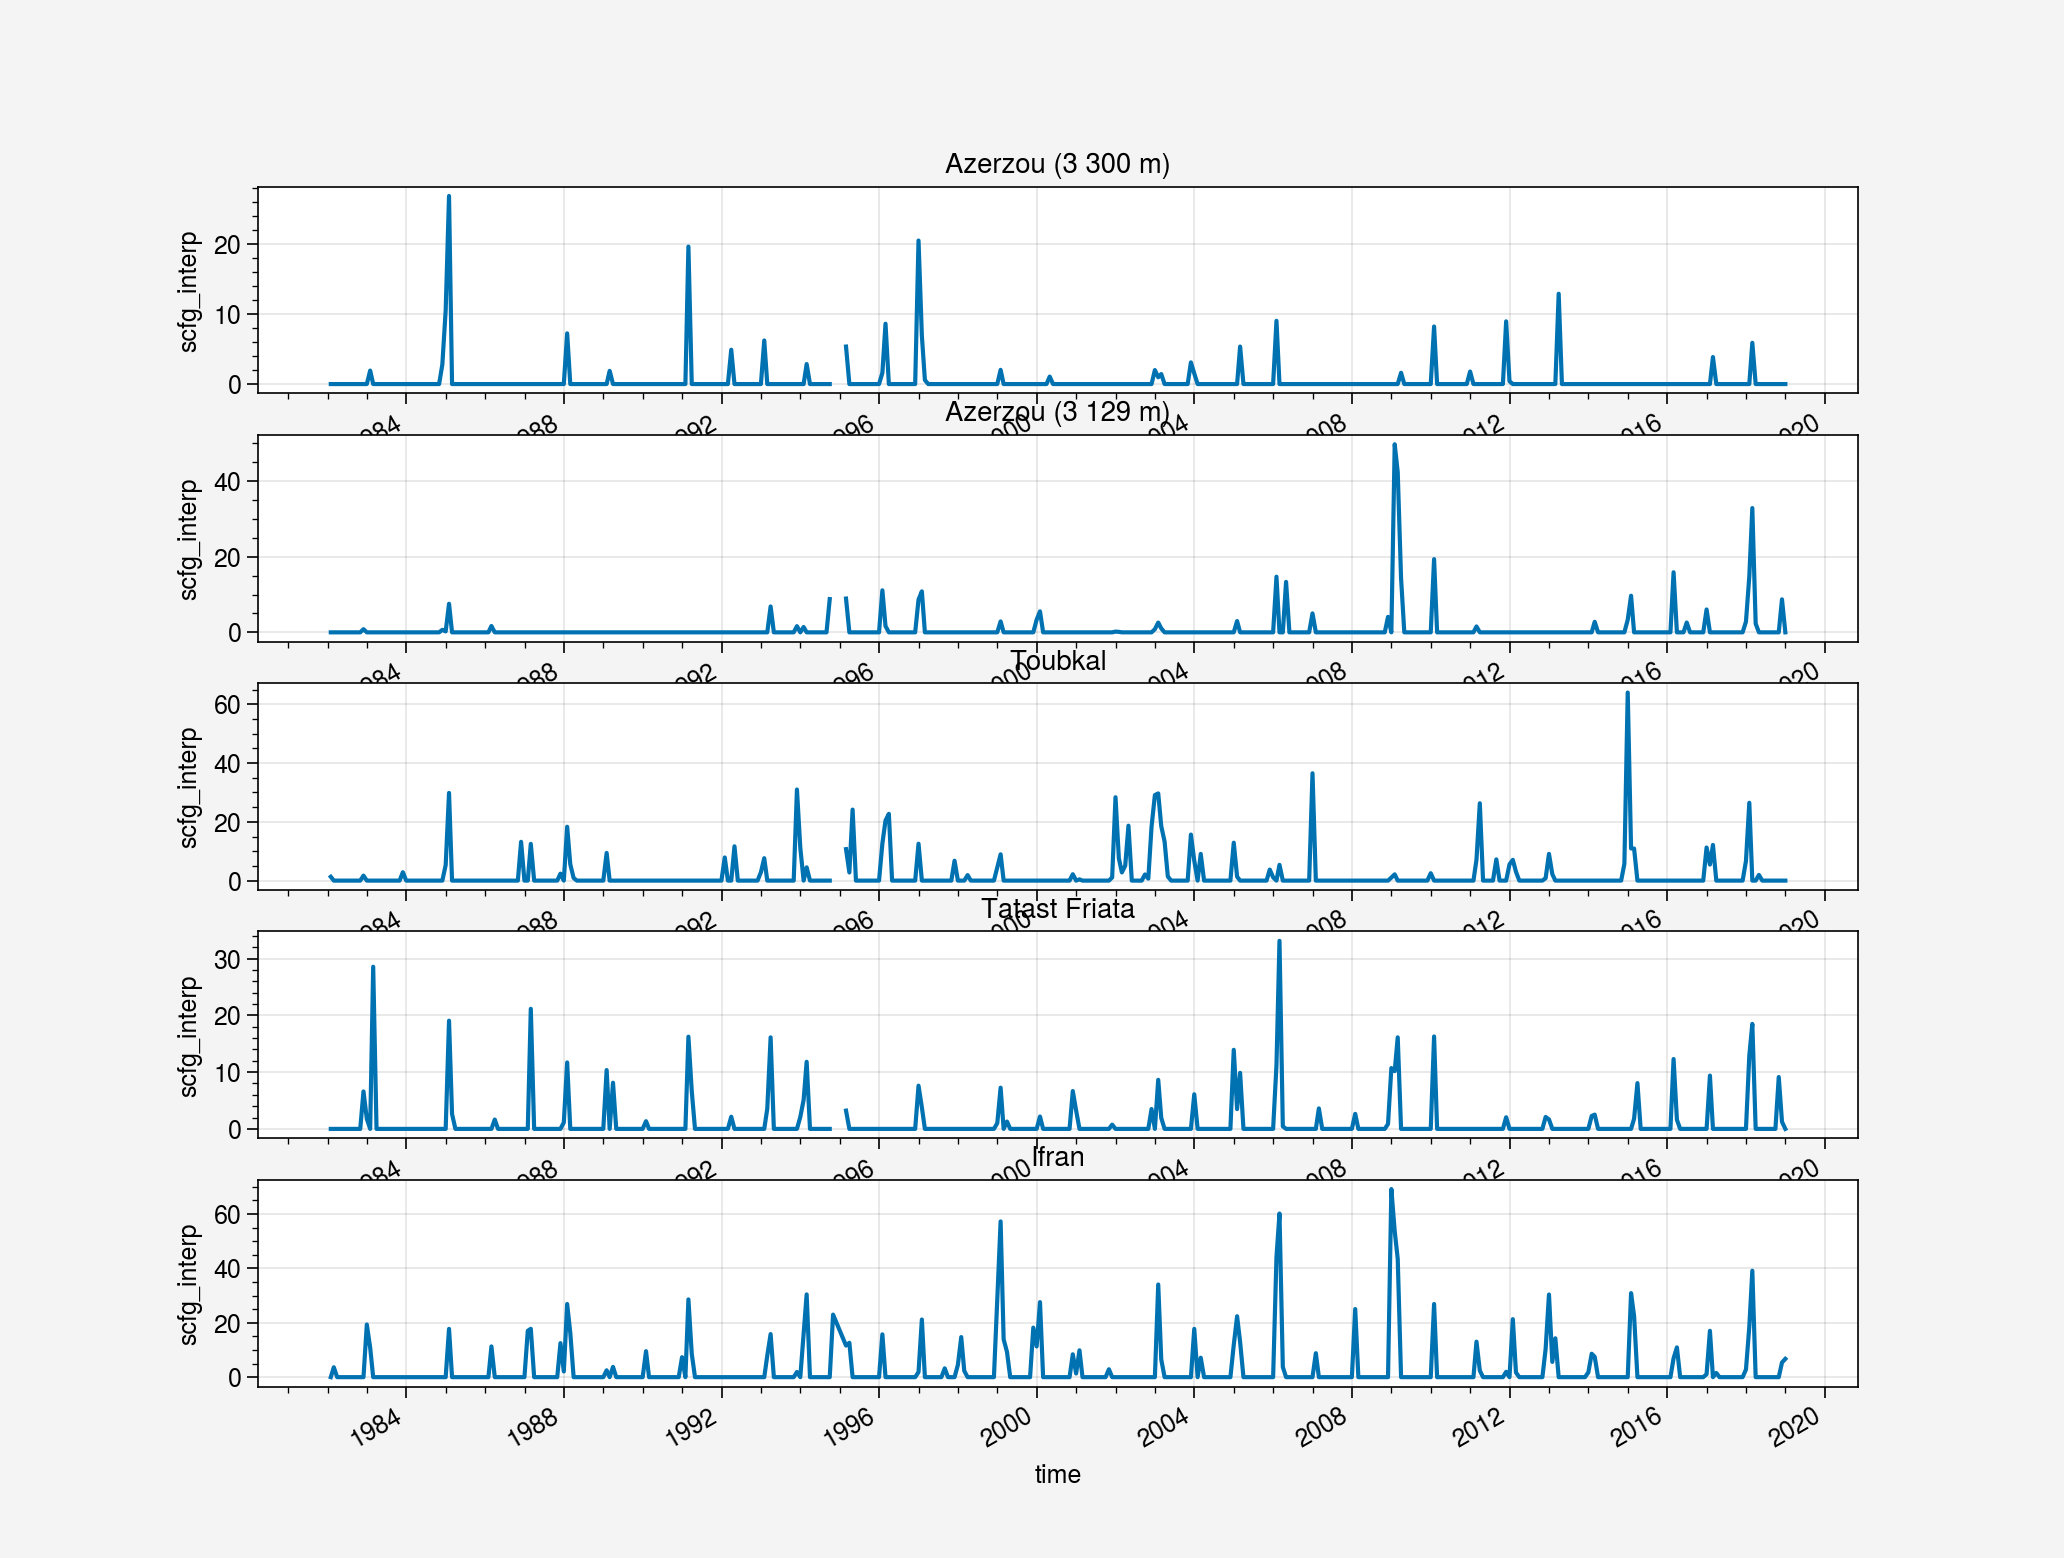

In [12]:
fig, axs=plt.subplots(ncols=1, nrows=5)

set_size(8,6)
xr.plot.line(P1[:,0,0], ax=axs[0])
axs[0].set_title("Azerzou (3 300 m)")

xr.plot.line(P2[:,0,0], ax=axs[1])
axs[1].set_title("Azerzou (3 129 m)")

xr.plot.line(P3[:,0,0], ax=axs[2])
axs[2].set_title("Toubkal")

xr.plot.line(P4[:,0,0], ax=axs[3])
axs[3].set_title("Tatast Friata")

xr.plot.line(P5[:,0,0], ax=axs[4])
axs[4].set_title("Ifran")

## 3. Monthly average vizualisation

<h1 style="font-size:1.2rem; color:black;"> We convert the xarray object into an array then list to facilitate its manipulation with matplotlib.pyplot </h1> 

In [13]:
P1mm = P1.groupby('time.month').mean(dim='time')
P2mm = P2.groupby('time.month').mean(dim='time')
P3mm = P3.groupby('time.month').mean(dim='time')                                    
P4mm = P4.groupby('time.month').mean(dim='time')
P5mm = P5.groupby('time.month').mean(dim='time')

In [14]:
ar1 = P1mm.to_numpy()
ar2 = P2mm.to_numpy()
ar3 = P3mm.to_numpy()                   
ar4 = P4mm.to_numpy()
ar5 = P5mm.to_numpy()

In [15]:
L1 = ar1[:,0,0].tolist()
L2 = ar2[:,0,0].tolist()
L3 = ar3[:,0,0].tolist()                                            
L4 = ar4[:,0,0].tolist()
L5 = ar5[:,0,0].tolist()

In [16]:
months=["Jan","Feb","Mar","April","May","Jun","Jul","Aug","Sep","Oct","Nov","Dec"]

Text(0, 0.5, 'scfg in %')

/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:238: RuntimeWarning: Glyph 8239 missing from current font.
  font.set_text(s, 0.0, flags=flags)
/home/hamid/anaconda3/envs/my_env/lib/python3.9/site-packages/matplotlib/backends/backend_agg.py:201: RuntimeWarning: Glyph 8239 missing from current font.
  font.set_text(s, 0, flags=flags)


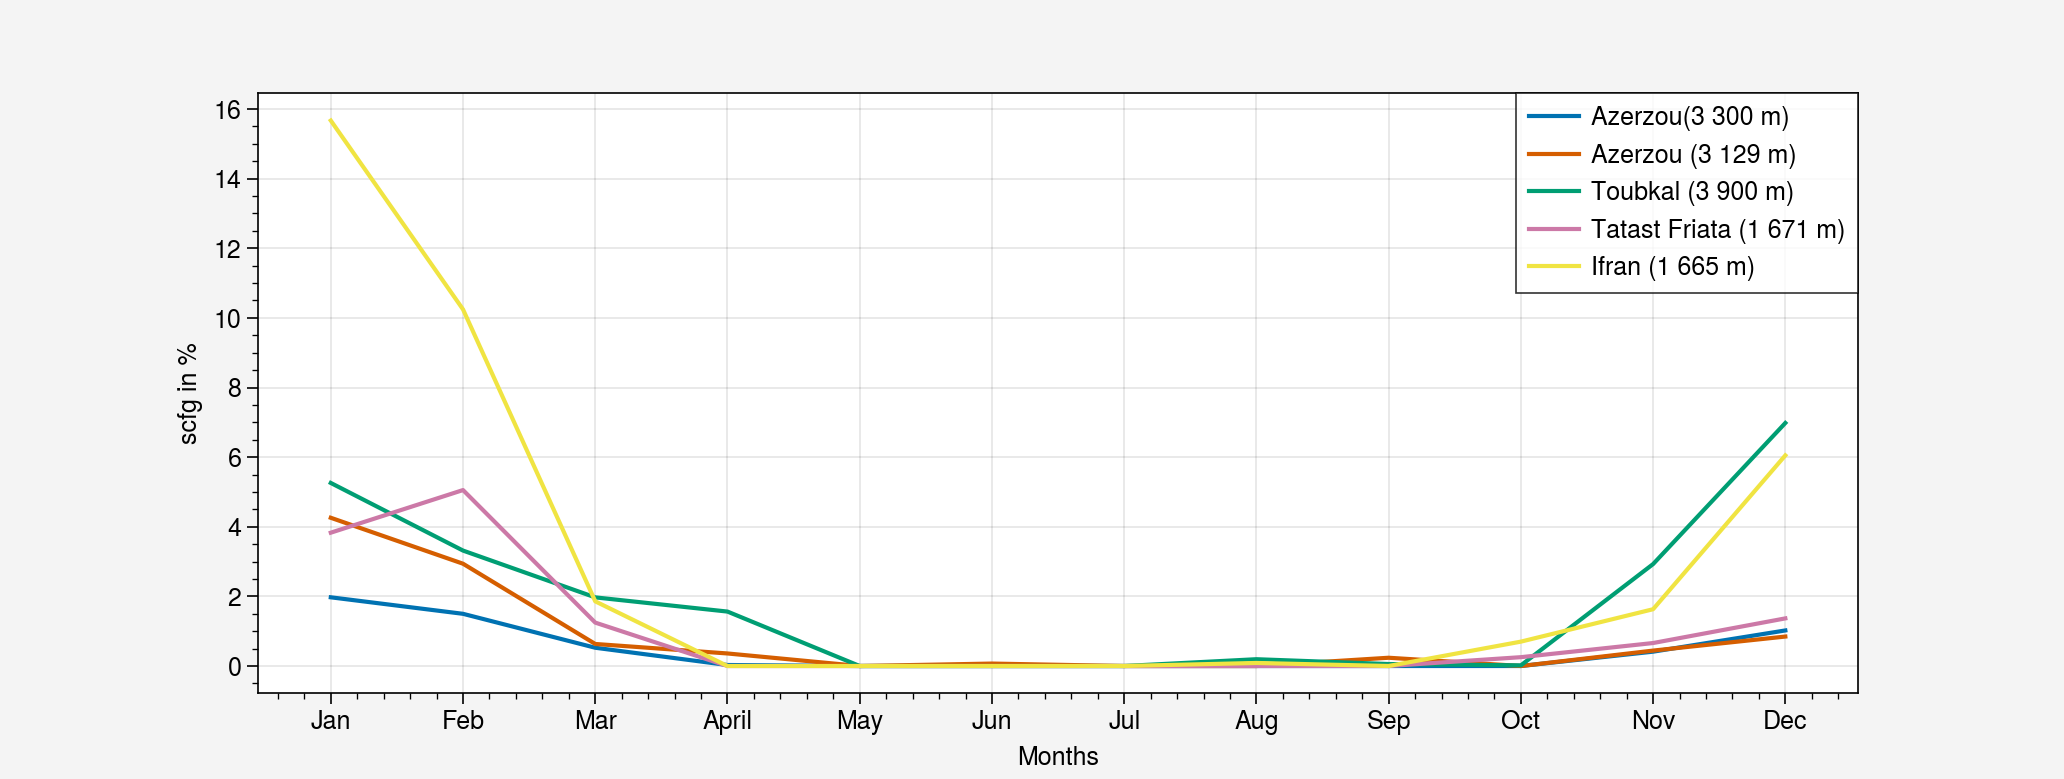

In [17]:
labels = ["Azerzou(3 300 m)","Azerzou (3 129 m)","Toubkal (3 900 m)","Tatast Friata (1 671 m)","Ifran (1 665 m)"]
fig, ax = plt.subplots()
set_size(8,3)
ax.plot(months, L1)
ax.plot(months, L2)
ax.plot(months, L3)
ax.plot(months, L4)
ax.plot(months, L5)
ax.legend(labels, ncol=1, loc='upper right')
plt.xlabel("Months")
plt.ylabel("scfg in %")

## 3. Monthly trend

In [18]:
P1g=P1.groupby('time.month')
P1m=[]
for m in range(1,13):
    aux = P1g[m] 
    aux = aux.to_numpy()
    aux = aux[:,0,0].tolist()
    aux = [x for x in aux if np.isnan(x) == False]
    P1m.append(aux)
    
P2g=P2.groupby('time.month')
P2m=[]
for m in range(1,13):  
    aux = P2g[m] 
    aux = aux.to_numpy()
    aux = aux[:,0,0].tolist()
    aux = [x for x in aux if np.isnan(x) == False]
    P2m.append(aux)
    
P3g=P3.groupby('time.month')
P3m=[]
for m in range(1,13):
    aux = P3g[m] 
    aux = aux.to_numpy()
    aux = aux[:,0,0].tolist()
    aux = [x for x in aux if np.isnan(x) == False]
    P3m.append(aux)
    
P4g=P4.groupby('time.month')
P4m=[]
for m in range(1,13):
    aux = P4g[m]                   
    aux = aux.to_numpy()
    aux = aux[:,0,0].tolist()
    aux = [x for x in aux if np.isnan(x) == False]
    P4m.append(aux)   

P5g=P5.groupby('time.month')
P5m=[]
for m in range(1,13):
    aux = P5g[m] 
    aux = aux.to_numpy()
    aux = aux[:,0,0].tolist()
    aux = [x for x in aux if np.isnan(x) == False]
    P5m.append(aux)         

In [47]:
values1 = P1m[:]
values2 = P2m[:]
values3 = P3m[:]
values4 = P4m[:]
values5 = P5m[:]

In [51]:
values1[0].insert(12,0)
values1[9].insert(11,0)
values1[10].insert(11,0)
values1[11].insert(11,0)

values2[0].insert(12,0)
values2[9].insert(11,0)
values2[10].insert(11,0)
values2[11].insert(11,0)

values3[0].insert(12,0)
values3[9].insert(11,0)
values3[10].insert(11,0)
values3[11].insert(11,0)

values4[0].insert(12,0)
values4[9].insert(11,0)
values4[10].insert(11,0)
values4[11].insert(11,0)

values5[0].insert(12,0)
#values5[9].insert(11,0)
values5[10].insert(11,0)
values5[11].insert(11,0)

Text(0.5, 0, 'Years')

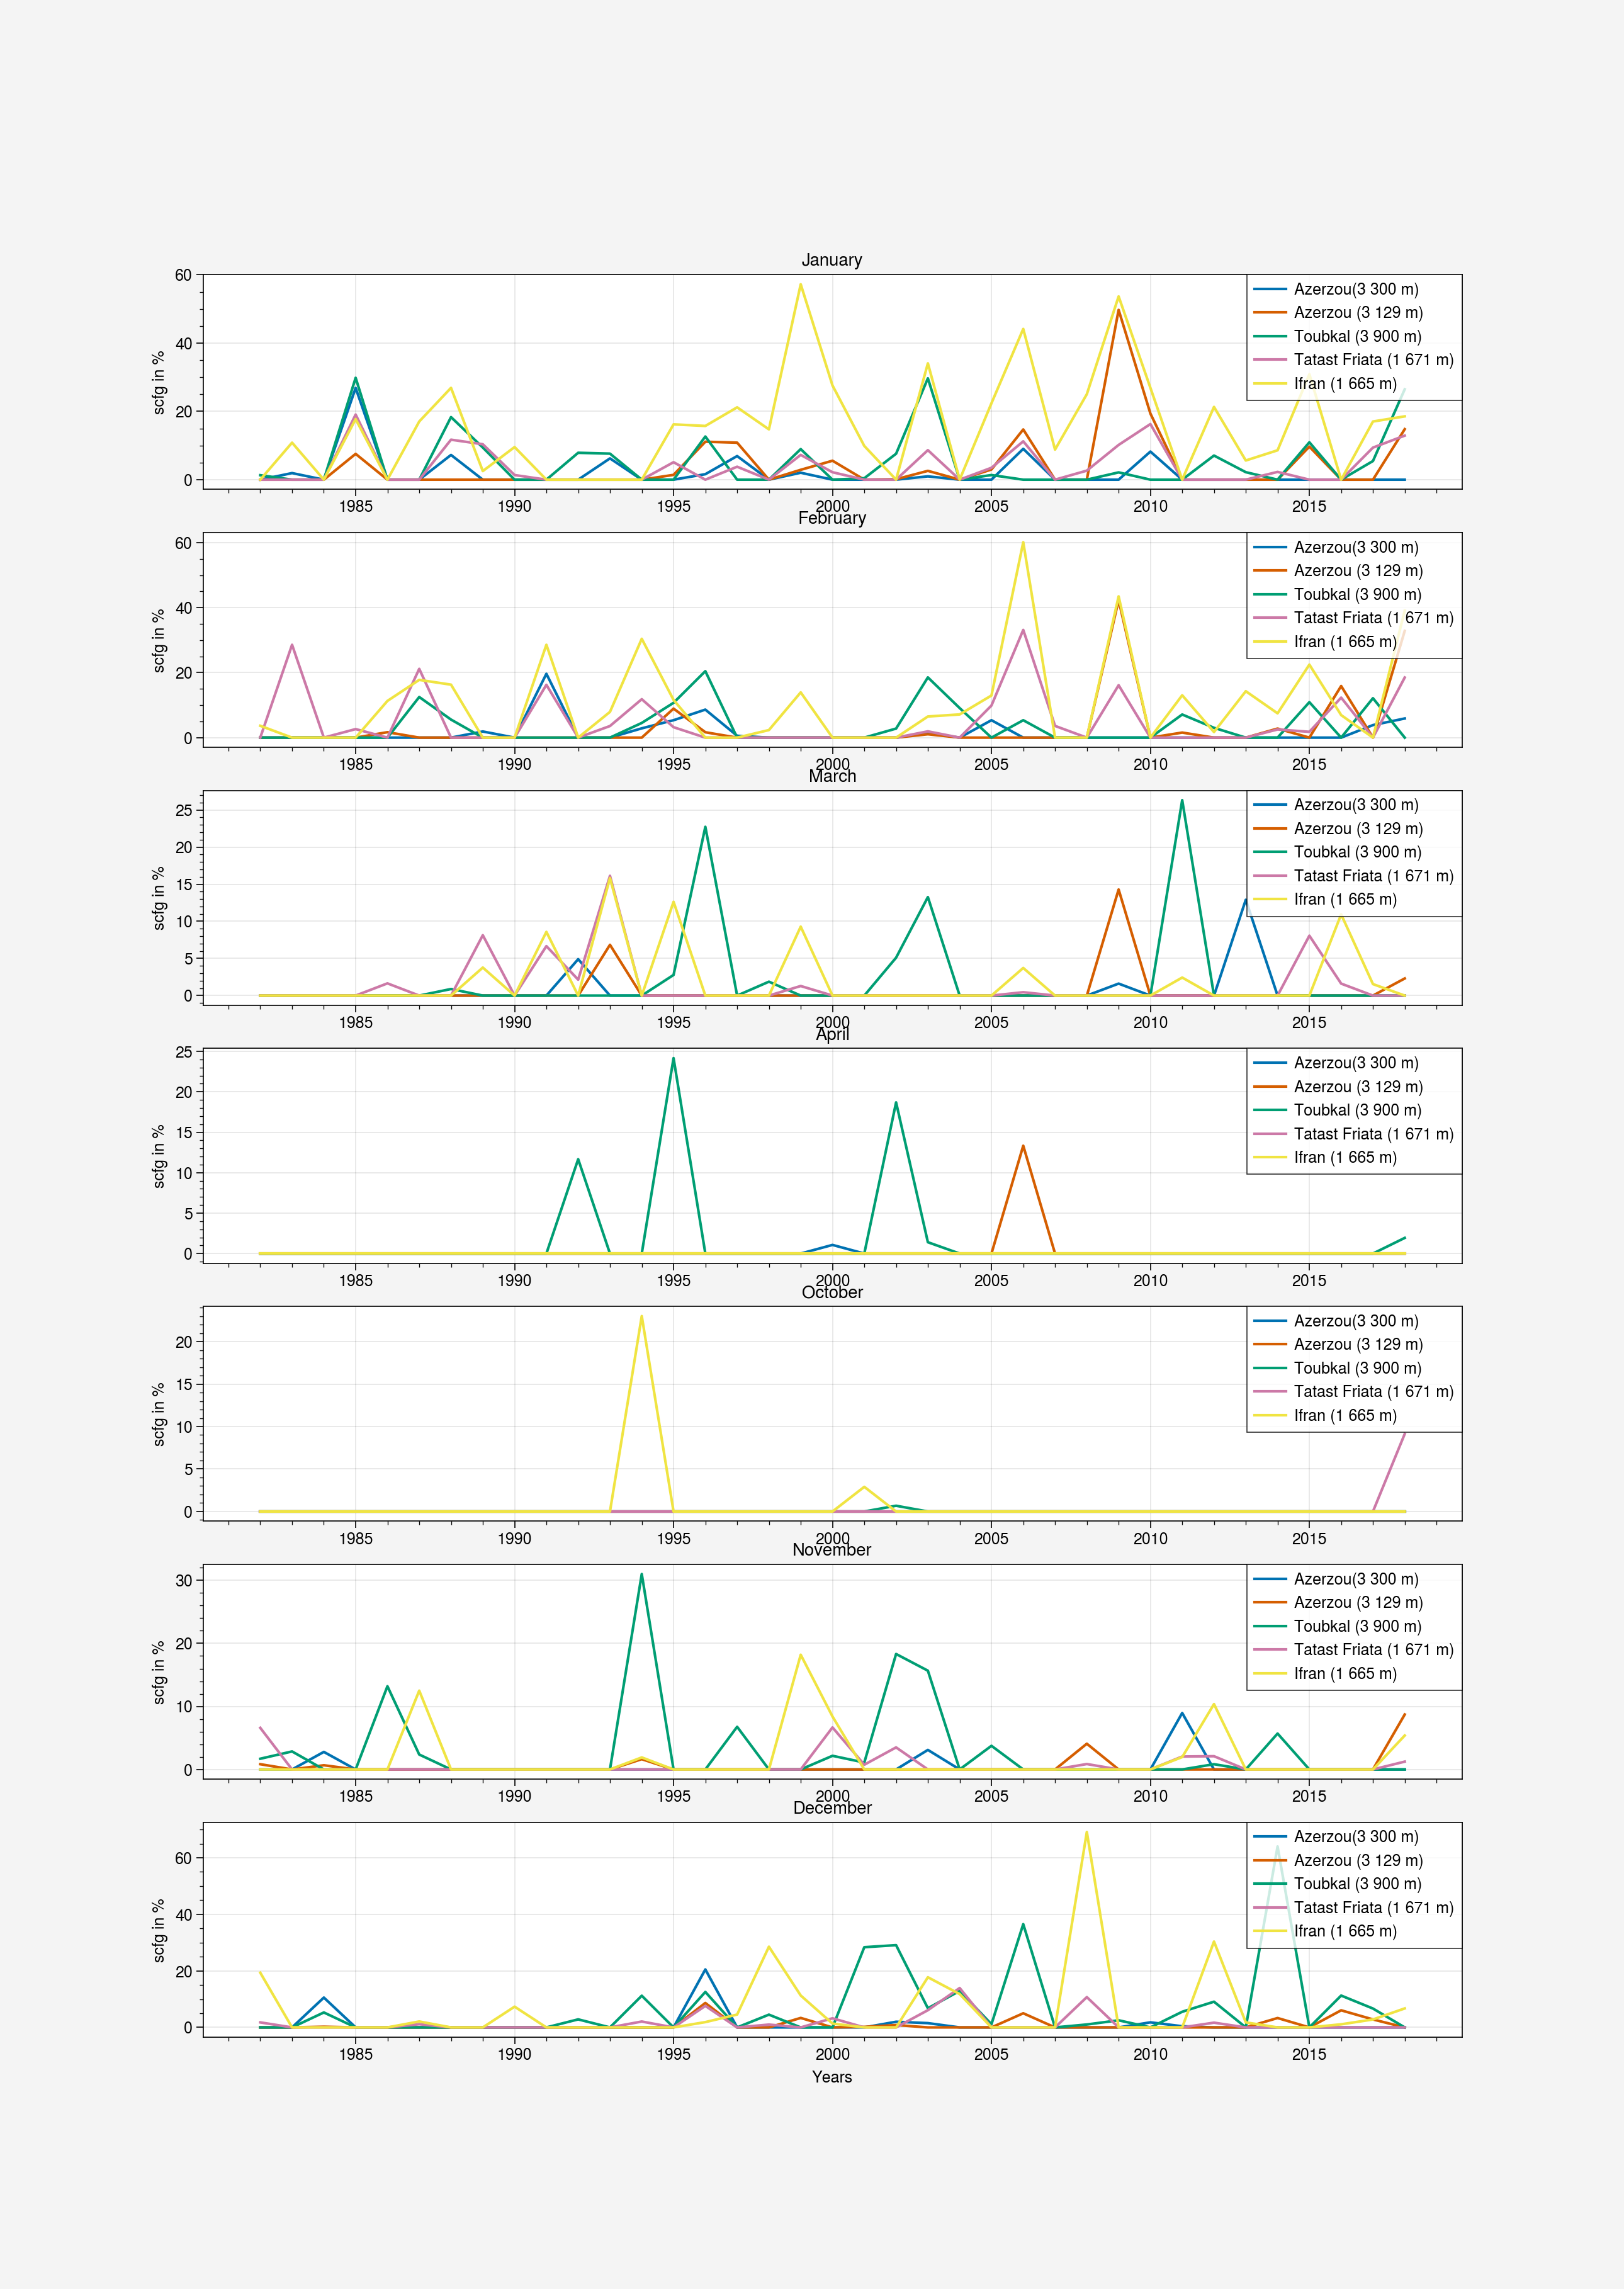

In [92]:
annes = [year for year in range(1982,2019)]
labels = ["Azerzou(3 300 m)","Azerzou (3 129 m)","Toubkal (3 900 m)","Tatast Friata (1 671 m)","Ifran (1 665 m)"]
months=["January", "February", "March", "April","October","November","December", "October", "November", "December"]
fig, ax = plt.subplots(ncols=1, nrows=7)
set_size(10,14)
j=0
for i in range(7):
    if j==4:
        j=9
    for value in [values1, values2, values3, values4, values5]:
        ax[i].plot(annes, value[j])
    j=j+1
    
    ax[i].set_title(months[i])
    ax[i].legend(labels, ncol=1, loc='upper right')
    ax[i].set_ylabel("scfg in %")
plt.xlabel("Years")

Text(0.5, 0, 'Years')

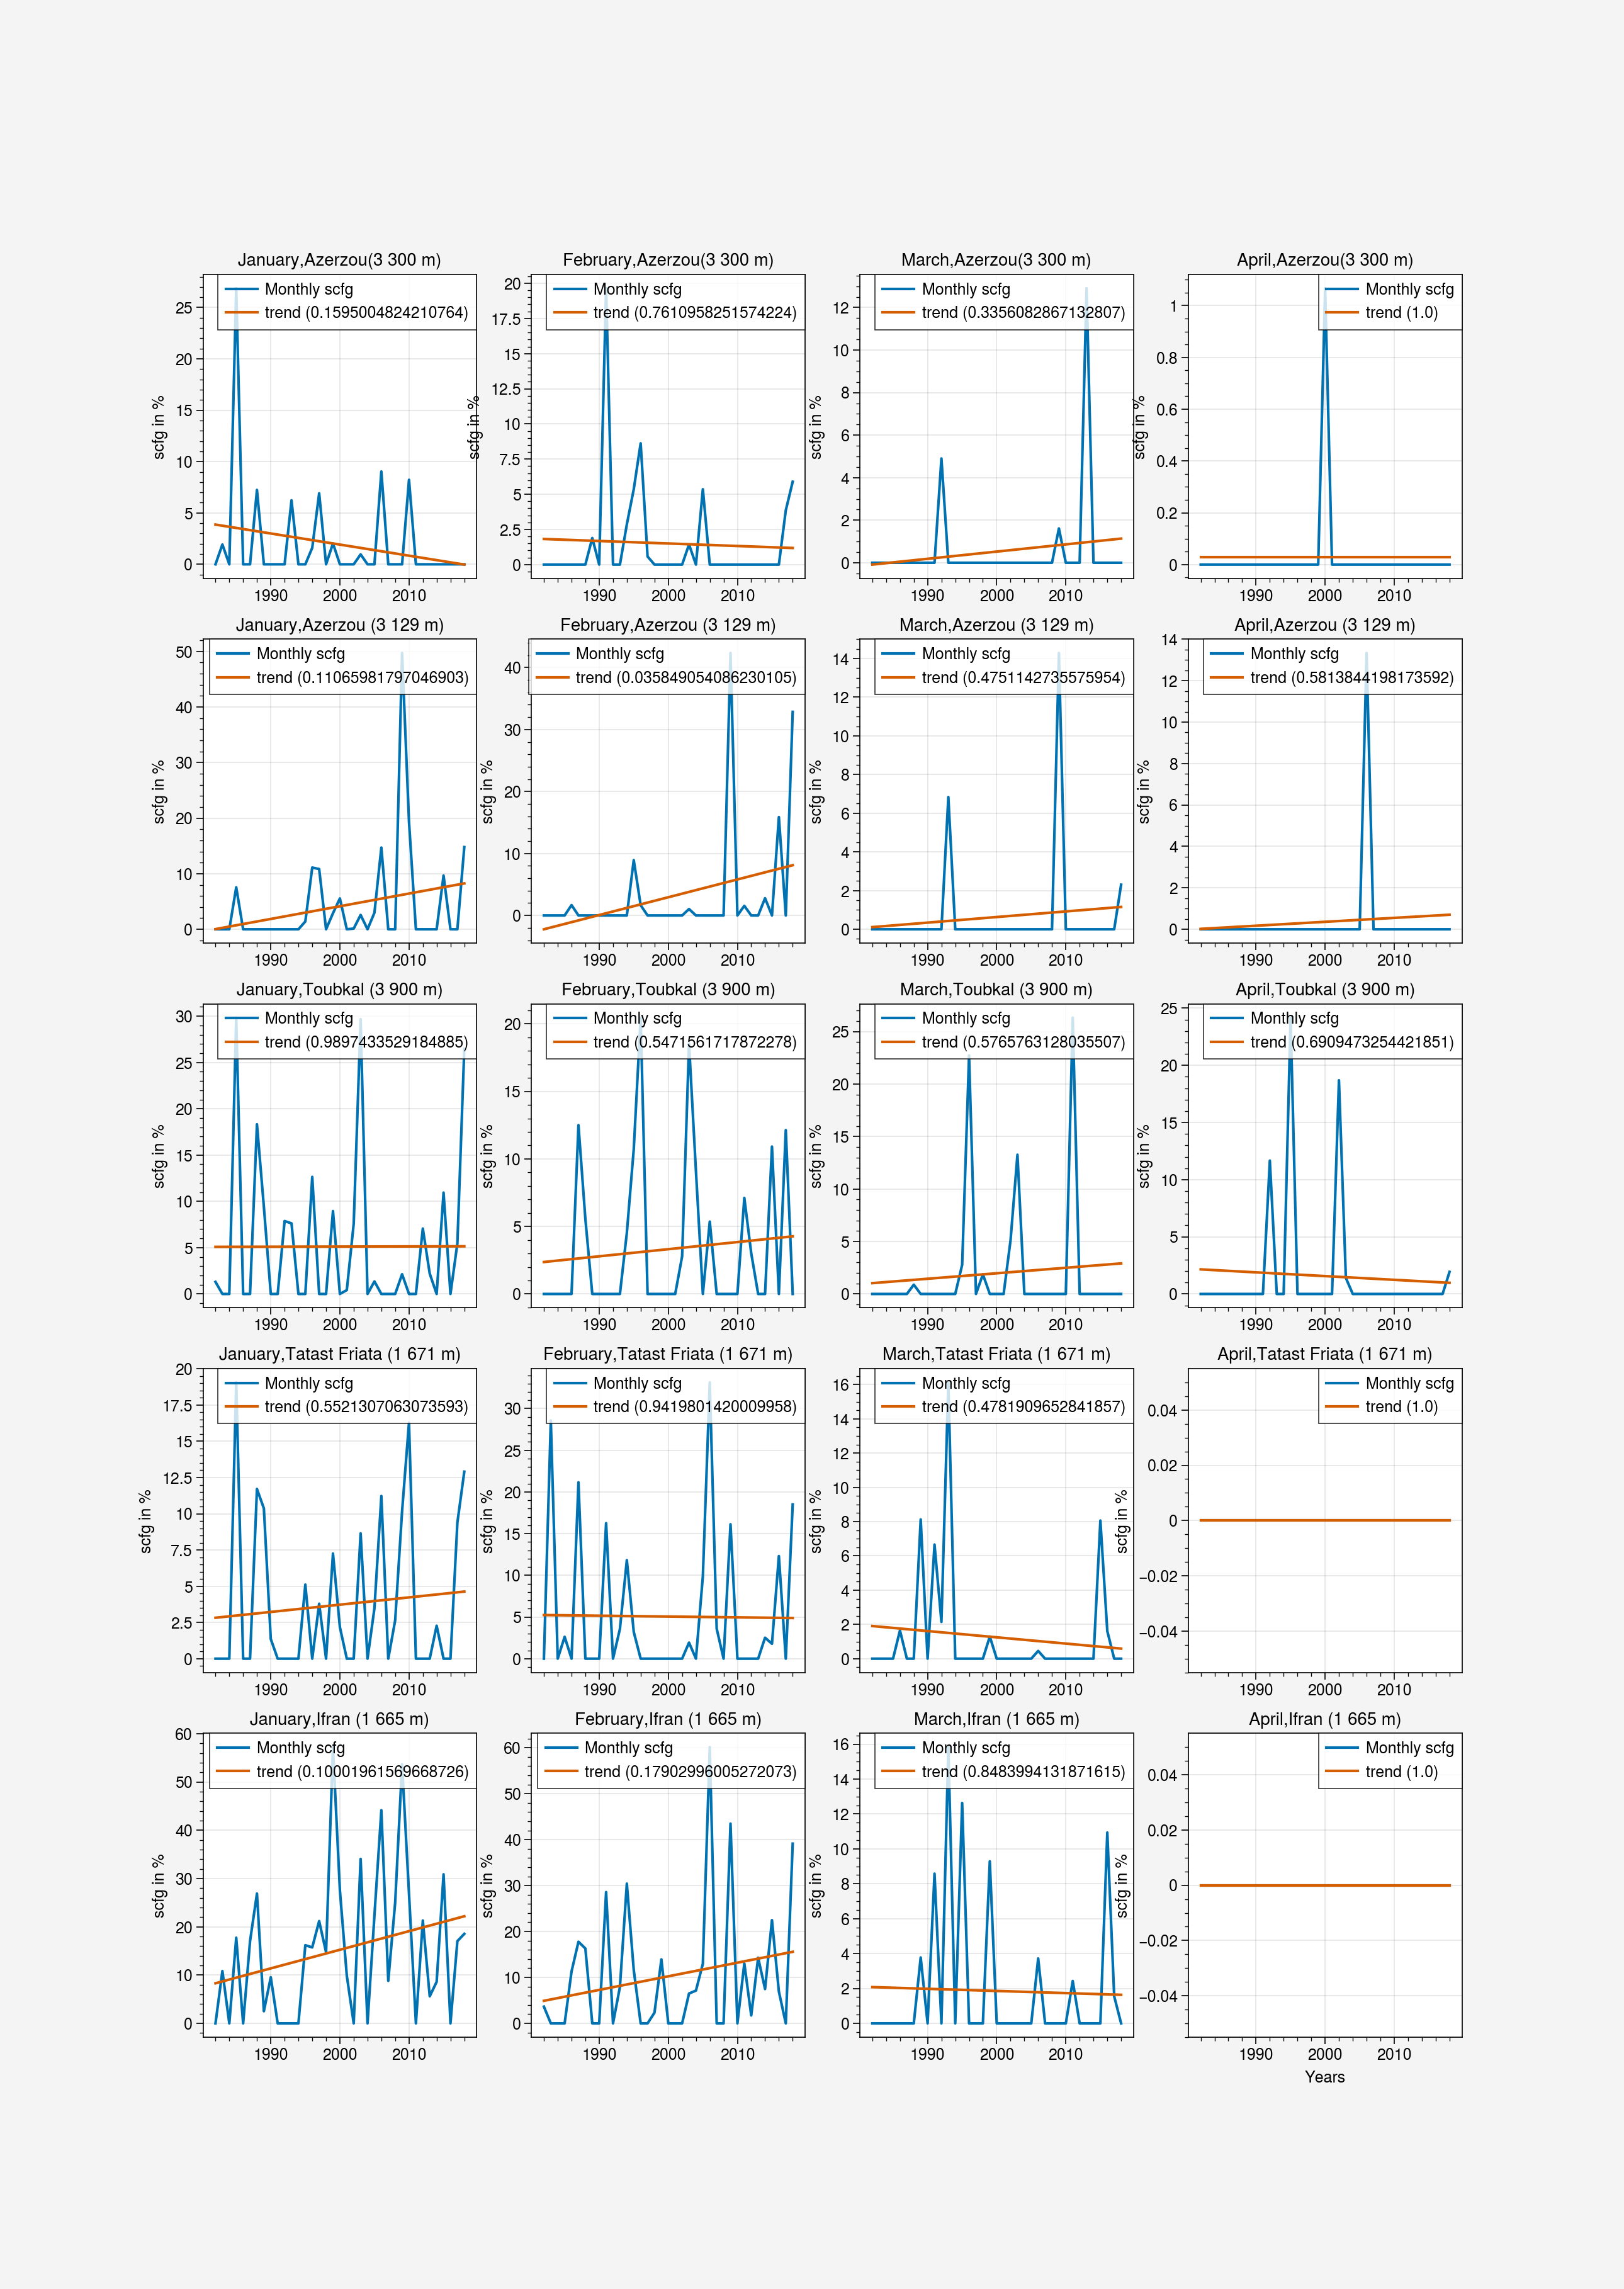

In [102]:
annes = [year for year in range(1982,2019)]
labels = ["Azerzou(3 300 m)","Azerzou (3 129 m)","Toubkal (3 900 m)","Tatast Friata (1 671 m)","Ifran (1 665 m)"]
months=["January", "February", "March", "April"]

fig, ax = plt.subplots(ncols=4, nrows=5)
set_size(10,14)
scfg = [values1, values2, values3, values4, values5]

for c in range(4):
    m=c
    for r in range(5):
        test = stats.linregress(annes, scfg[r][m])
        slope = test.slope
        pvalue = test.pvalue
        intercept = test.intercept
        trend = [y*slope+intercept for y in annes]
        ax[r][c].plot(annes, scfg[r][m])
        ax[r][c].plot(annes, trend)
        ax[r][c].set_title(months[m]+","+labels[r])
        ax[r][c].legend(["Monthly scfg", "trend ("+str(pvalue)+")"], ncol=1, loc='upper right')
        ax[r][c].set_ylabel("scfg in %")
plt.xlabel("Years")

Text(0.5, 0, 'Years')

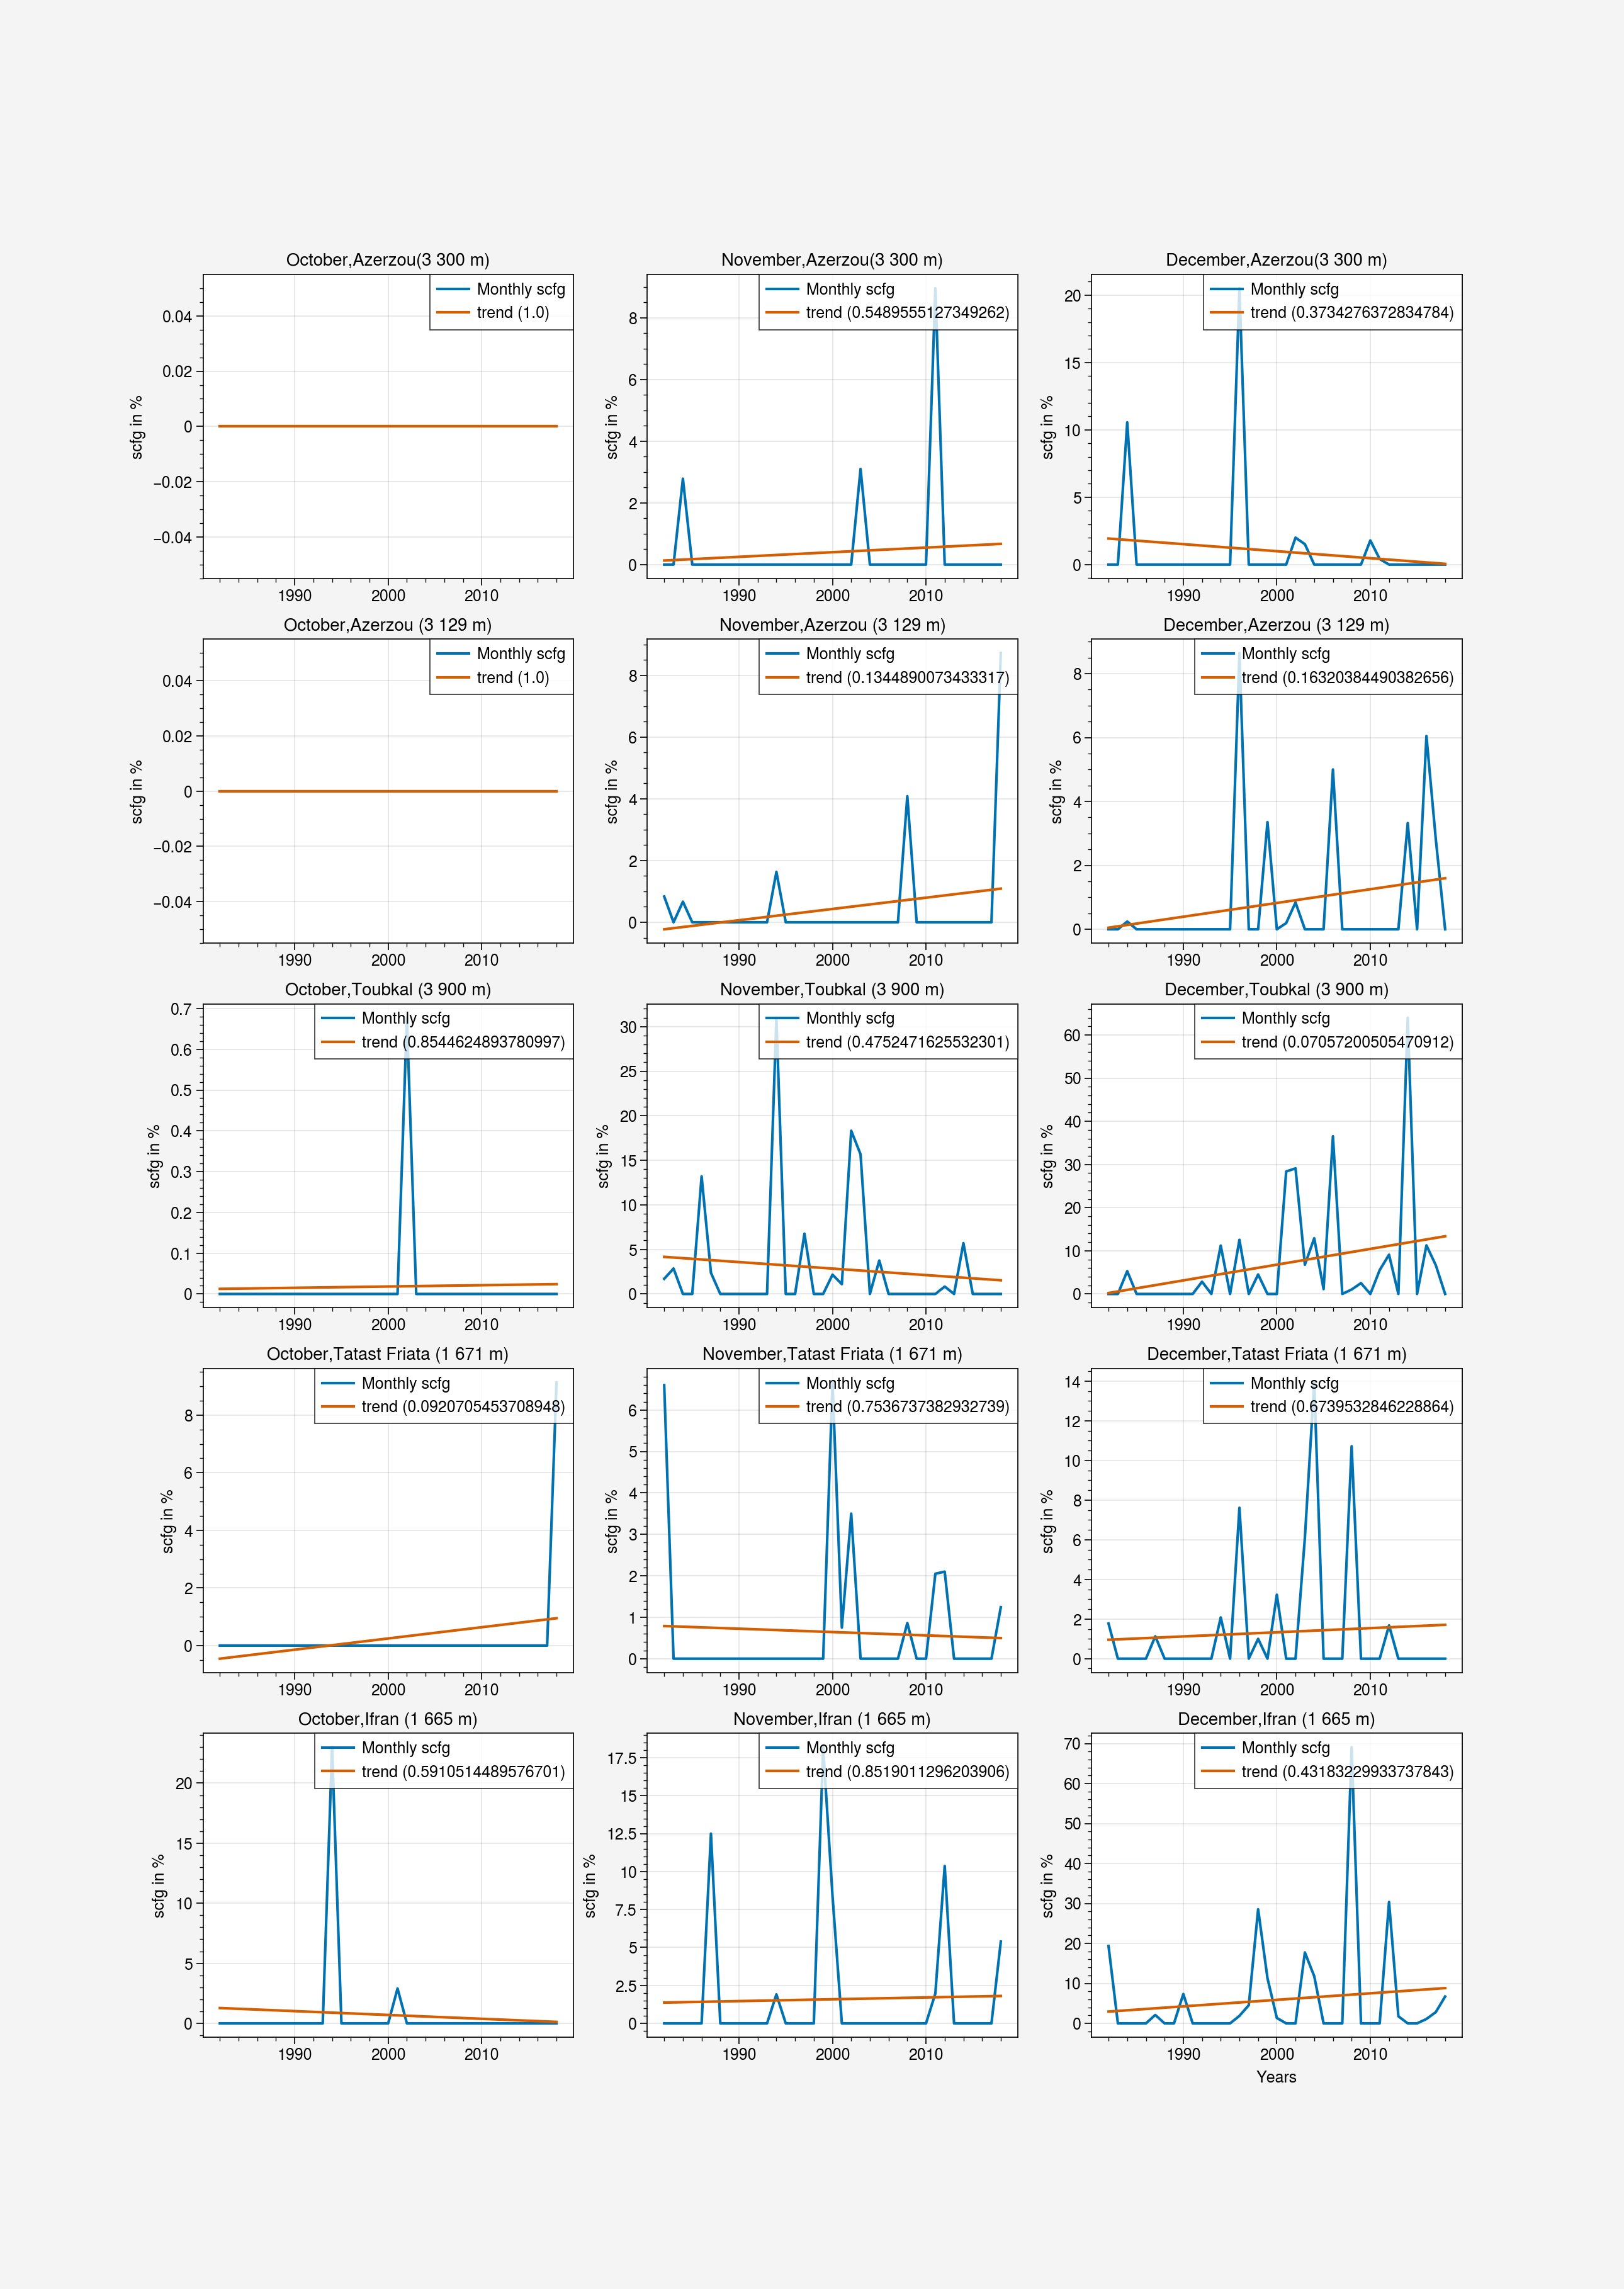

In [107]:
annes = [year for year in range(1982,2019)]
labels = ["Azerzou(3 300 m)","Azerzou (3 129 m)","Toubkal (3 900 m)","Tatast Friata (1 671 m)","Ifran (1 665 m)"]
months=["October", "November", "December"]

fig, ax = plt.subplots(ncols=3, nrows=5)
set_size(10,14)
scfg = [values1, values2, values3, values4, values5]

for c in range(3):
    m=9+c
    for r in range(5):
        test = stats.linregress(annes, scfg[r][m])
        slope = test.slope
        pvalue = test.pvalue
        intercept = test.intercept
        trend = [y*slope+intercept for y in annes]
        ax[r][c].plot(annes, scfg[r][m])
        ax[r][c].plot(annes, trend)
        ax[r][c].set_title(months[c]+","+labels[r])
        ax[r][c].legend(["Monthly scfg", "trend ("+str(pvalue)+")"], ncol=1, loc='upper right')
        ax[r][c].set_ylabel("scfg in %")
plt.xlabel("Years")